# Simulations for MEDUSAE

## 1. Simulate field seen through WFIRST with no coronagraph

In [1]:
import numpy as np
from astropy.io import fits 
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'


Populating the interactive namespace from numpy and matplotlib


In [16]:
haystacks = fits.open('cube_marie.fits')[0].data
print(haystacks.shape)
wl = np.array([650.,750.,850.])

(3, 129, 129)


In [8]:
import poppy
import webbpsf
import astropy.units as u
from webbpsf import wfirst # https://github.com/neilzim/webbpsf.git, branch cgi_ab
webbpsf.setup_logging() 

dist_pc = 3
pix_scale_au = 0.057*dist_pc/4
asec_per_pix = pix_scale_au/dist_pc
import logging as log
log.info("Plate scale is %.3f per pixel" % asec_per_pix)
spc_model = wfirst.CGI(mode = 'CHARSPC_F660', pixelscale=asec_per_pix)


WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.
[webbpsf] Set the following optical configuration:
[webbpsf] camera = IFS, filter = F660, apodizer = CHARSPC, fpm = CHARSPC_F660_BOWTIE, lyotstop = LS30D88


### Create PSF at corresponding wavelength

[  poppy] Initialized OpticalSystem: unnamed system
[  poppy] Optic from /Users/mrizzo/IFS/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits: Loaded amplitude transmission from /Users/mrizzo/IFS/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: Optic from /Users/mrizzo/IFS/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added detector with pixelscale=0.01425 and oversampling=2: Detector
[  poppy] Calculating PSF with 1 wavelengths
[  poppy]  Propagating wavelength = 6.5e-07 m
[  poppy]   Calculation completed in 0.427 s
[  poppy] PSF Calculation completed.


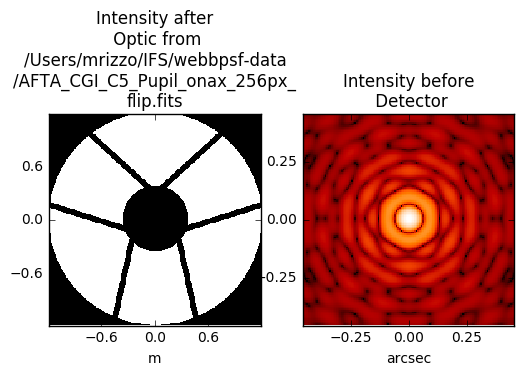

In [9]:

wfirst_tel = poppy.OpticalSystem()
wfirst_tel.addPupil(transmission=spc_model.pupil)
wfirst_tel.addDetector(asec_per_pix, fov_arcsec=asec_per_pix*64)

lam = wl[0]
wfirst_tel_psf = wfirst_tel.calcPSF(wavelength=lam*1e-9, display_intermediates=True)
psf = wfirst_tel_psf[0].data
plt.figure(figsize=(4,4))
plt.imshow(psf)
plt.title('WFIRST Normalized PSF')
plt.colorbar()


### Select a slice of the cube and convolve it with the PSF

In [15]:
from scipy.signal import convolve2d

(129, 129) 64 554.938598641


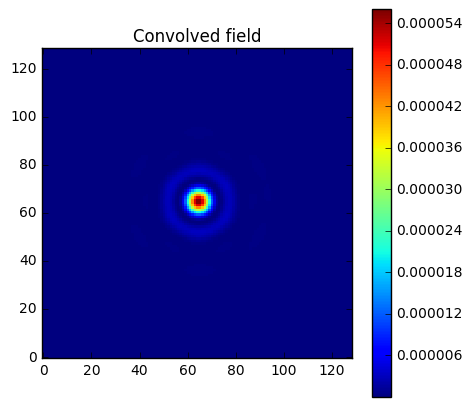

In [27]:
haystacks = fits.open('cube_marie.fits')[0].data
cubeslice = haystacks[0]
center = int(cubeslice.shape[0]/2)
print(cubeslice.shape,center,cubeslice[center,center])
cubeslice[center,center] *= 1e-5
res = convolve2d(cubeslice,psf,mode='same')
plt.figure(figsize=(5,5))
plt.imshow(res)
plt.title('Convolved field')
plt.colorbar()


## Automate process for cube - All-in-one

Populating the interactive namespace from numpy and matplotlib
WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.
0.01425
[webbpsf] Set the following optical configuration:
[webbpsf] camera = IFS, filter = F660, apodizer = CHARSPC, fpm = CHARSPC_F660_BOWTIE, lyotstop = LS30D88
(3, 129, 129)
[  poppy] Initialized OpticalSystem: unnamed system
[  poppy] Optic from /Users/mrizzo/IFS/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits: Loaded amplitude transmission from /Users/mrizzo/IFS/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: Optic from /Users/mrizzo/IFS/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added detector with pixelscale=0.01425 and oversampling=2: Detector
[  poppy] Calculating PSF with 1 wavelengths
[  poppy]  Propagating wavelength = 6.5e-07 m
[  poppy]   Calculation completed in 0.296 s
[  poppy] PSF Calculation completed.
[  poppy] Calculating PSF with 1 wave

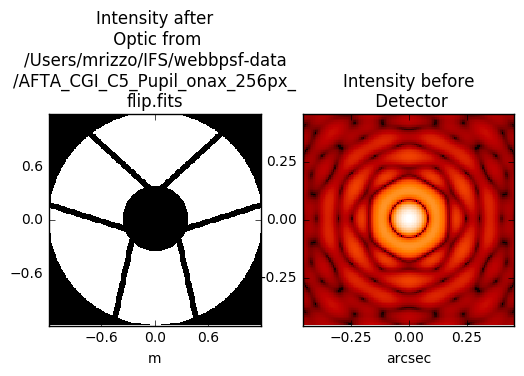

In [4]:
import numpy as np
from astropy.io import fits 
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

import poppy
import webbpsf
import astropy.units as u
from webbpsf import wfirst # https://github.com/neilzim/webbpsf.git, branch cgi_ab
webbpsf.setup_logging() 

from scipy.signal import convolve2d
dist_pc = 3
pix_scale_au = 0.057*dist_pc/4
asec_per_pix = pix_scale_au/dist_pc
print (asec_per_pix)
import logging as log
log.info("Plate scale is %.3f per pixel" % asec_per_pix)
spc_model = wfirst.CGI(mode = 'CHARSPC_F660', pixelscale=asec_per_pix)

haystacks = fits.open('cube_marie.fits')[0].data
print(haystacks.shape)
wl = np.array([650.,750.,850.])

Npix = 128
wfirst_tel = poppy.OpticalSystem()
wfirst_tel.addPupil(transmission=spc_model.pupil)
wfirst_tel.addDetector(asec_per_pix, fov_arcsec=asec_per_pix*Npix/2)
outcube = np.zeros((len(wl),Npix,Npix))

## value by which the star brightness is decreased
contrast_attenuation = 1e-6

for i in range(len(wl)):
    lam = wl[i]
    wfirst_tel_psf = wfirst_tel.calcPSF(wavelength=lam*1e-9, display_intermediates=True)
    psf = wfirst_tel_psf[0].data
    haystacks = fits.open('cube_marie.fits')[0].data
    cubeslice = haystacks[0]
    center = int(cubeslice.shape[0]/2)
    cubeslice[center,center] *= contrast_attenuation
    res = convolve2d(cubeslice,psf,mode='same')
    outcube[i] = res[:outcube.shape[1],:outcube.shape[2]]

    
out = fits.HDUList(fits.PrimaryHDU(np.asarray(outcube)))
out.writeto('WFIRST-PUPIL_ONLY.fits', clobber=True)

In [6]:
import logging
log = logging.getLogger('webbpsf')
log.info('test')

[webbpsf] test
